In [45]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import re
import warnings


In [46]:
# Ignore all future warnings
warnings.simplefilter(action='ignore')

In [47]:
sns.set_theme(style="darkgrid", palette="rainbow")
%matplotlib inline

## Preprocessing

In [48]:
hotel = pd.read_csv("hotel.csv")

Như phân tích ở trên chúng ta chỉ quan tâm đến một số columns trong `hotel` dataframe

In [49]:
hotel.columns.to_list()

['hotel_id',
 'hotel_name',
 'addressline1',
 'city',
 'state',
 'numberrooms',
 'yearopened',
 'yearrenovated',
 'number_of_reviews',
 'rating_average',
 'star_rating',
 'accommodation_type']

### Missing Data

In [50]:
missing = hotel.isna().sum()
missing
# Percentage to whole collumns
missing = round(missing[missing != 0]*100/len(hotel),2).sort_values(ascending=True)
missing

addressline1           0.02
accommodation_type     0.10
state                  5.52
numberrooms            7.61
yearopened            82.14
yearrenovated         89.62
dtype: float64

Text(0.5, 1.0, 'Missing Data Histogram')

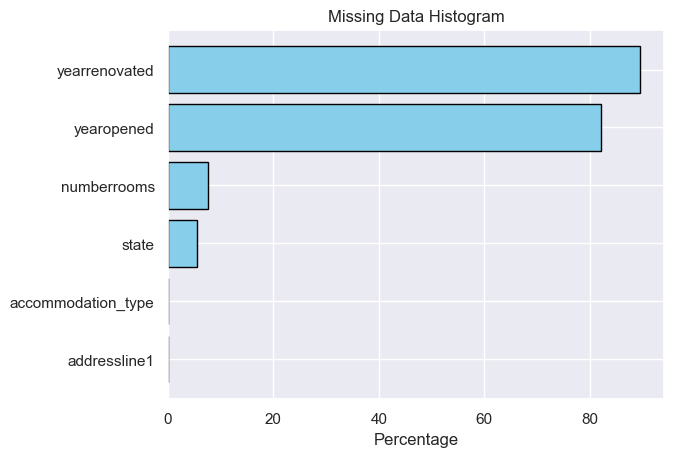

In [51]:
plt.barh(missing.index, missing.values, color='skyblue', edgecolor='black')
plt.xlabel('Percentage')
plt.title('Missing Data Histogram')

Về phần xử lý **missing data**, chúng ta sẽ following theo các step sau:
- Hai cột `yearrenovated` và `yearopened` mình sẽ giữ nguyên. Do dữ liệu ở đây missing quá nhiều, tuy nhiên những dữ liệu không missing lại chiếm phần lớn thông tin.
- `numberrooms` chiểm khoảng 7% số lượng data: Ta sẽ chuẩn hóa nó về trung bình dựa trên  trung bình `numberrooms` theo `star_rating`.
- `state` chiếm khoảng 5.5% số lượng data: Ta sẽ xử lý dựa trên mode của theo `city`, do `city` không có giá trị null.
- `addressline1` là giá trị primary nên ta không thể tùy tiện xử lý nó được nên sẽ drop các rows có giá trị `addressline1` là null.
- `accomadation_type` ta sẽ đưa về mode của `accomadation_type`.

**Note**: Do đây là bài toán về phân tích reviews nên nếu số lượng reviews của những cột missing data này quá ít, ta cũng sẽ không cần xét. Cụ thể là ít hơn 5 reviews.

In [52]:
hotel_new = hotel[hotel['number_of_reviews'] > 5 ]
print(hotel_new.shape[0],'/' ,hotel.shape[0])

10295 / 29446


In [53]:
missing = hotel_new.isna().sum()
missing = round(missing[missing != 0]*100/len(hotel),2).sort_values(ascending=True)
missing

accommodation_type     0.08
state                  2.12
numberrooms            3.94
yearopened            19.56
yearrenovated         25.94
dtype: float64

Text(0.5, 1.0, 'Missing Data Histogram')

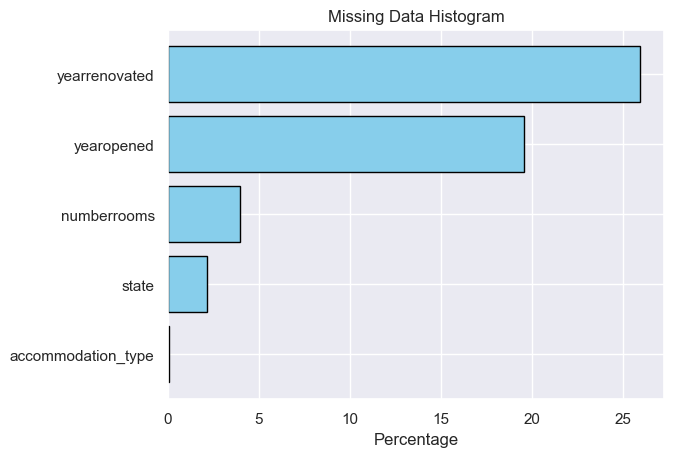

In [54]:
plt.barh(missing.index, missing.values, color='skyblue', edgecolor='black')
plt.xlabel('Percentage')
plt.title('Missing Data Histogram')

Việc xử lý sẽ vẫn dựa trên ý tưởng như trên:

In [55]:
# numberrooms
for index, row in hotel_new[hotel_new['numberrooms'].isnull()].iterrows():
    try:
        data = hotel_new[hotel_new['star_rating'] == row['star_rating']].numberrooms
        mean_value = round(data.mean())
        hotel_new.loc[index, 'numberrooms'] = mean_value
    except:
        hotel_new.drop(index=index, inplace=True)
        
# state
for index, row in hotel_new[hotel_new['state'].isnull()].iterrows():
    try:
        data = hotel_new[hotel_new['city'] == row['city']].state
        mode_value = data.mode().iloc[0]
        hotel_new.loc[index, 'state'] = mode_value
    except IndexError:
        hotel_new.drop(index=index, inplace=True)

# addressline1
hotel_new.dropna(subset=['addressline1'], how='all', inplace=True)

# accommodation_type
hotel_new.accommodation_type = hotel_new['accommodation_type'].fillna(hotel_new['accommodation_type'].mode()[0])

In [56]:
missing = hotel_new.isna().sum()
missing = round(missing[missing != 0]*100/len(hotel),2).sort_values(ascending=True)
missing

yearopened       19.55
yearrenovated    25.93
dtype: float64

In [58]:
hotel_new.to_csv('hotel_new.csv', index=False, encoding='utf-8-sig')

### Duplicated Data

In [57]:
hotel_new.duplicated().all() == False

True

Chúng ta có thể chắc chắn **không có duplicated rows** trong dataset.

### Outlier Data

Do hầu hết data của bài toán là dạng **quantitative features** nên việc phân tích outlier cho dạng không có nhiều ý nghĩa nên chúng ta sẽ bỏ qua bước này.

# Feature Scaling

Text(0.5, 1.0, 'Boxplot of Numerical Variable')

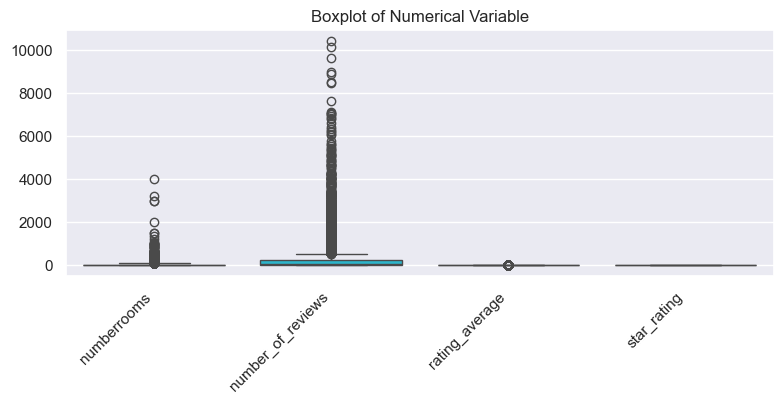

In [40]:
numeVar = hotel_new[['numberrooms', 'number_of_reviews', 'rating_average', 'star_rating']]

plt.figure(figsize=(8, 4))
sns.boxplot(data=numeVar)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title('Boxplot of Numerical Variable')

In [42]:
from sklearn.preprocessing import StandardScaler

scaled_numeVar = StandardScaler().fit_transform(numeVar)

scaled_numeVar = pd.DataFrame(scaled_numeVar, index = numeVar.index, columns = numeVar.columns)
scaled_numeVar

,numberrooms,number_of_reviews,rating_average,star_rating
0,2.534592,2.136272,-0.348992,0.808676
1,2.407054,8.930605,0.659762,1.448960
2,0.700010,3.058221,0.547678,0.808676
3,1.416184,1.049956,-0.236908,0.808676
4,2.927016,0.707774,0.099343,1.448960
...,...,...,...,...
27603,0.121184,-0.414404,1.780598,0.808676
27656,-0.359535,-0.411416,1.780598,-1.112178
27908,0.081942,-0.381531,1.108096,0.168391
28133,-0.359535,-0.374060,1.668515,1.448960


Text(0.5, 1.0, 'Boxplot of Numerical Variable')

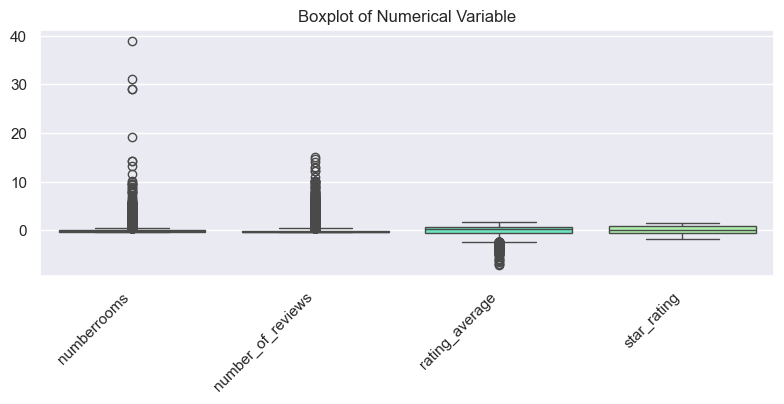

In [44]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=scaled_numeVar)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title('Boxplot of Numerical Variable')